# Mapping atom analysis
Valid for experiments from 2025-04-30 until ...


In [230]:
date_filters = ["2025-11-19","2025-11-20","2025-11-21","2025-11-22"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints
import math
import itertools

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan","Microwaves_scans"], # find files containing any of these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=False
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

found 85 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-19\08\000031681-Microwaves_scans.h5) scanned over f_microwaves_dds
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-19\08\000031681-Microwaves_scans_microwave_Rabi_2_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-19\08\000031682-Microwaves_scans.h5) scanned over f_microwaves_dds
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-19\08\000031682-Microwaves_scans_microwave_Rabi_2_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-19\09\000031683-Microwaves_scans.h5) scanned over f_microwaves_dds
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-19\09\000031683-Microwaves_scans_microwave_Rabi_2_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds
file 6 

## Combine files - Fitting resonanc

experiment: microwave_Rabi_2_experiment
override: {'dummy_variable':4}
# of iterations:  30
center=336898972.1720±1203.8729, sigma=31560.8010±1435.5393, ampl=0.9035±0.0319, base=0.9276±0.0158
experiment: microwave_Rabi_2_experiment
override: {'dummy_variable':4}
# of iterations:  30
center=336898725.2909±1109.2013, sigma=33003.6959±1344.6123, ampl=0.8854±0.0277, base=0.9021±0.0144
experiment: microwave_Rabi_2_experiment
override: {'dummy_variable':4}
# of iterations:  30
center=336895073.1777±1194.1786, sigma=31702.2760±1426.7410, ampl=0.8863±0.0309, base=0.9142±0.0154
experiment: microwave_Rabi_2_experiment
override: {'dummy_variable':4}
# of iterations:  30
center=336890575.8715±922.4164, sigma=32152.8548±1107.4686, ampl=0.9348±0.0249, base=0.9477±0.0126
experiment: microwave_Rabi_2_experiment
override: {'dummy_variable':4}
# of iterations:  30
center=336896416.2853±1116.3274, sigma=31964.6082±1337.4432, ampl=0.9036±0.0292, base=0.9310±0.0147
experiment: microwave_Rabi_2_experiment
o

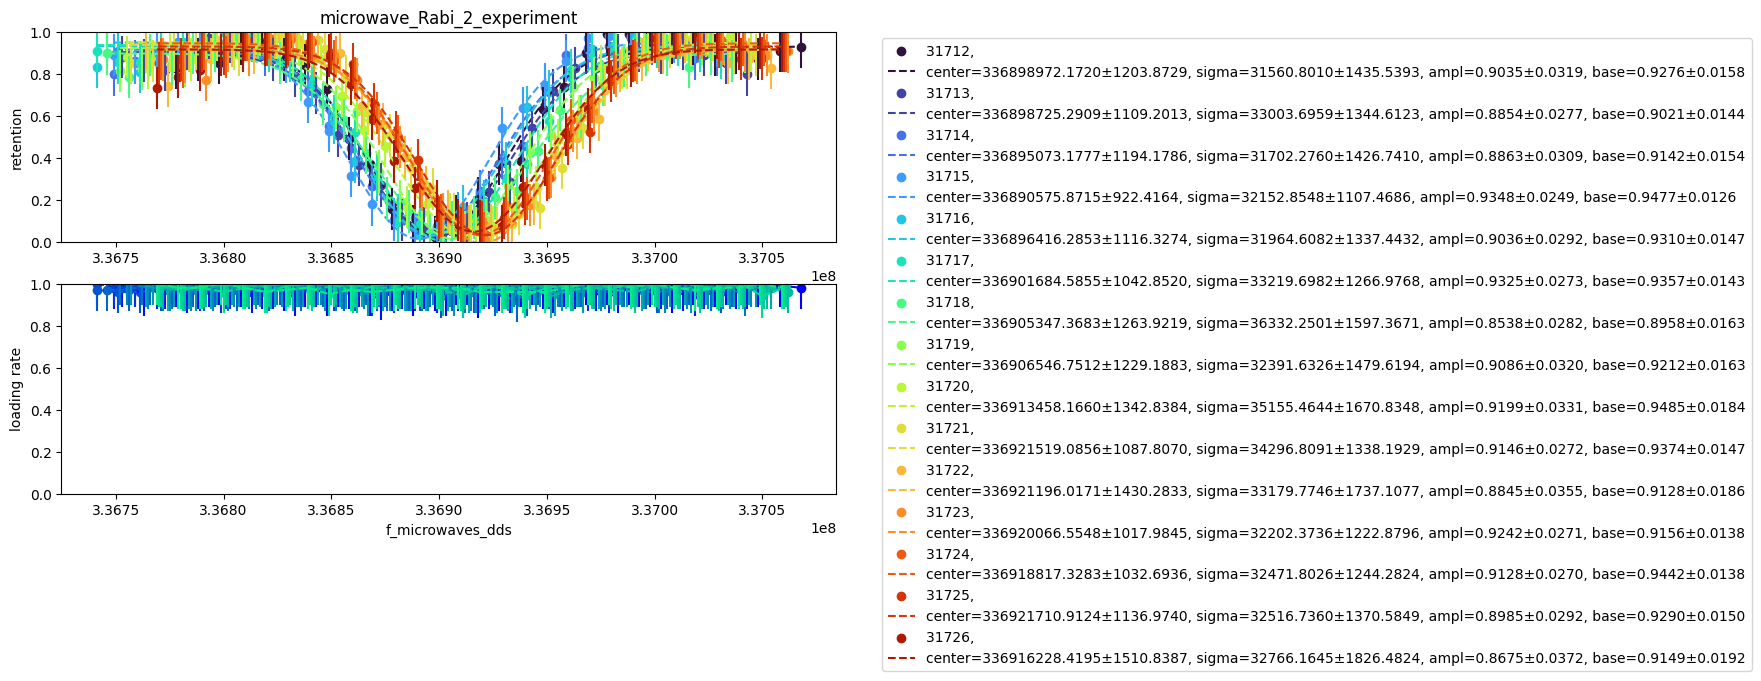

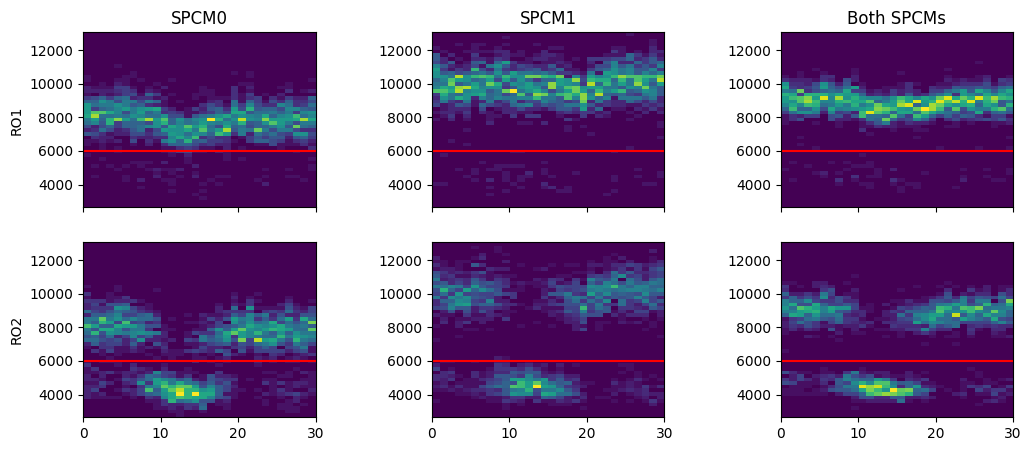

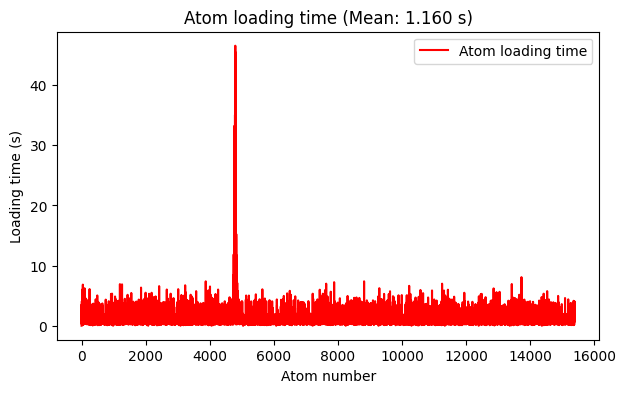

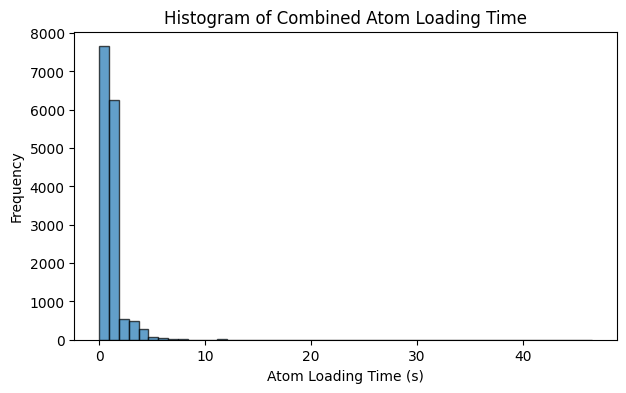

In [231]:
"""
With fitting the resonance for microwave scans

"""
# ### the file(s) to analyze:
# file_indices = {
#     0:'',
#     26:'',
#     38:'',
#     36:'HWP=1.875, QWP=4.5',
#     38:'HWP=0.5, QWP=4.5',
#     38:'',
#     40:'',
# } 

file_indices = {i: '' for i in range(55, 84, 2)}

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = True
is_it_a_peak = False ### use True if the resonance we are trying to fit shows as a peak. False for a dip resonance.

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=False, figsize=(10, 6))
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


SPCM0_RO1_hists = []
SPCM0_RO2_hists = []
SPCM1_RO1_hists = []
SPCM1_RO2_hists = []
BothSPCMs_RO1_hists = []
BothSPCMs_RO2_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''

all_atom_loading_times = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)

    all_atom_loading_times.append(Atom_loading_time)
    
    if otsu_threshold:
        thresh = threshold_otsu(BothSPCMs_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot
    if showhist:
        SPCM0_RO1_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM0_RO2_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO1_hists.append(
            [np.histogram(SPCM1_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO2_hists.append(
            [np.histogram(SPCM1_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])
        
        BothSPCMs_RO1_hists.append(
            [np.histogram(BothSPCMs_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        BothSPCMs_RO2_hists.append(
            [np.histogram(BothSPCMs_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=False)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            ### for fitting
            ### Auto-detect rough center from minimum retention
            fit_dict = {}

            ### initial guesses for center/sigma/ampl/base
            x = scan_sequence1
            y = retention
            
            ### Use edges to estimate baseline (less affected by the resonance feature)
            edge = max(1, len(y)//10)
            base0 = float(np.median(np.r_[y[:edge], y[-edge:]]))
            
            ### Width guess ~ 1/10 of scan span (tweak if needed)
            sigma0 = max( (x.max() - x.min())/10.0, 1e-12 )
            
            ### Peak/dip center and ampl guesses
            center0_peak = float(x[np.argmax(y)])
            center0_dip  = float(x[np.argmin(y)])
            ampl0_peak  = max(float(y.max() - base0), 1e-6)
            ampl0_dip   = max(float(base0 - y.min()), 1e-6)
            
            ### the fit model. using gaussian for now
            if is_it_a_peak:
                fit_dict = {
                    scan_variable1_name: {
                        # peak: base + ampl * exp(...)
                        'model': lambda x, center, sigma, ampl, base: base + ampl * np.exp(-((x - center)**2)/(2*sigma**2)),
                        'p0':    [center0_peak, sigma0, ampl0_peak, base0],
                        # bounds: center in scan range, sigma>0, ampl>=0, base in [0,1] for retention
                        'bounds': ([x.min(), 0.0, 0.0, 0.0],
                                   [x.max(), np.inf, 1.5, 1.0]),
                        'params': ['center', 'sigma', 'ampl', 'base']
                    }
                }
            else:
                fit_dict = {
                    scan_variable1_name: {
                        # dip: base - ampl * exp(...)
                        'model': lambda x, center, sigma, ampl, base: base - ampl * np.exp(-((x - center)**2)/(2*sigma**2)),
                        'p0':    [center0_dip, sigma0, ampl0_dip, base0],
                        'bounds': ([x.min(), 0.0, 0.0, 0.0],
                                   [x.max(), np.inf, 1.5, 1.0]),
                        'params': ['center', 'sigma', 'ampl', 'base']
                    }
                }
                

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, pcov = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                perr = np.sqrt(np.diag(pcov))  # Parameter uncertainties
                # fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2] ### without errors
                fit_str = ", ".join(f"{p}={v:.4f}±{e:.4f}" for p, v, e in zip(fit_dict[scan_variable1_name]['params'], popt, perr)) ### with errors
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            # ax_ret.grid(True)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True)  # 2 rows, 3 columns
    ax, ax2, ax3, ax4, ax5, ax6 = axes.ravel()  # Flatten the 2D axes array for easier unpacking

    ### Plot for SPCM0 RO1 in the 1st row, 1st column
    cax = ax.imshow(np.array(SPCM0_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax.set_ylabel("RO1")
    ax.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax.set_aspect('auto')
    ax.set_title("SPCM0")

    ### Plot for SPCM1 RO1 in the 1st row, 2nd column
    cax2 = ax2.imshow(np.array(SPCM1_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax2.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax2.set_aspect('auto')
    ax2.set_title("SPCM1")

    ### Plot for BothSPCMs RO1 in the 1st row, 3rd column
    cax3 = ax3.imshow(np.array(BothSPCMs_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax3.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax3.set_aspect('auto')
    ax3.set_title("Both SPCMs")

    ### Plot for SPCM0 RO2 in the 2nd row, 1st column
    cax4 = ax4.imshow(np.array(SPCM0_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax4.set_ylabel("RO2")
    ax4.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax4.set_aspect('auto')

    ### Plot for SPCM1 RO2 in the 2nd row, 2nd column
    cax5 = ax5.imshow(np.array(SPCM1_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax5.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax5.set_aspect('auto')

    ### Plot for BothSPCMs RO2 in the 2nd row, 3rd column
    cax6 = ax6.imshow(np.array(BothSPCMs_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax6.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax6.set_aspect('auto')

    plt.subplots_adjust(hspace=0.2, wspace=0.5)
plt.show()



#### Plot the combined Atom_loading_time values
## We can slice the array to separate iterations later, if we want.
combined_atom_loading_times = list(itertools.chain(*all_atom_loading_times))
mean_loading_time = np.mean(combined_atom_loading_times)
plt.figure(figsize=(7, 4))
plt.plot(combined_atom_loading_times, 'r-', label='Atom loading time')
plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)") 
# plt.title(f"Combined Atom Loading Time for All Files")
plt.legend(loc='best')
plt.show()

# Plot the histogram of combined Atom_loading_time
plt.figure(figsize=(7, 4))
plt.hist(combined_atom_loading_times, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Atom Loading Time (s)")
plt.ylabel("Frequency")
plt.title(f"Histogram of Combined Atom Loading Time")
plt.show()

# microwave mapping fidelity analysis

Protocol for MW_01:

0- You need to know the fidelity of optical pumping, hyperfine selective readout, and blowaway from other experiments.

1- Use microwave_Rabi_2_experiment but disable microwave in the code to measure the base retention (off-resonance) R_off_reson. You can use np.average(retention_array) to find the retention as done below.

2- Use microwave_Rabi_2_experiment to scan f01 which shows a dip on resonance. Find the retention on-resonance (R_on_reson) from the fit. See below.

3- Calculate the amplitude by ampl = abs(R_off_reson - R_on_reson) and plug it into the code below for F=1,mF=0 → F=2,mF=1 fidelity


For MW_11 (F=2,mF=1 → F=1,mF=1) mapping fidelity:

1- Use microwave_map01_map11_experiment but disable the 2nd MW pulse to measure the base retention (off-resonance) R_off_reson. You can use np.average(retention_array) to find the retention.

2- Use microwave_map01_map11_experiment to scan f11 which shows a peak on resonance. Find the retention on-resonance (R_on_reson) from the fit.

3- Calculate the amplitude by ampl = abs(R_off_reson - R_on_reson) and plug it into the 2nd code below for F=2,mF=1 → F=1,mF=1 fidelity

## Map MW_01  (F=1,mF=0 → F=2,mF=1)

In [42]:
### finding the retention from off-resonant microwave experiment
R_off_reson = np.average(retention_array)
dR_off_reson = np.average(binomial_err(n_atoms_loaded_array,retention_array)) ### error
print(f"Far off resonant retention   =  {R_off_reson:.4f} ± {dR_off_reson:.4f}   from RID {rid}")

Far off resonant retention   =  0.9766 ± 0.0148   from RID 31605


In [58]:
### Finding R_on_reson from the fit parameters from microwave scan experiment
ampl = popt[2]
base = popt[3] 
R_on_reson = abs(base - ampl) ### see the fit model above
dR_on_reson = perr[2]+perr[3]
print(f"On resonant retention   =  {R_on_reson:.4f} ± {dR_on_reson:.4f}   from RID {rid}")

On resonant retention   =  0.0450 ± 0.0489   from RID 31567


In [91]:
"""
These values are obtained from various experiments, including the MW frequency scan to find the resonance ampl.

"""

F_pump_RO_corrected = 0.987      # optical pumping fidelity from experiment below
dF_pump_RO_corrected = 0.012      # error

F_hyperfine_selective_RO = 0.9881      # hyperfine-selective readout fidelity (overall) from Readout_and_blowaway_fidelity.ipynb
dF_hyperfine_selective_RO = 0.0028     # error

### Blowaway calibration from Readout_and_blowaway_fidelity.ipynb
s1   = 0.9970         # survival probability if atom is in F=1 before blowaway
ds1  = 0.0038         # err
e2   = 0.9878          # ejection efficiency if atom is in F=2 before blowaway
de2  = 0.0042          # err
s2 = 1.0 - e2      # survival if initially F=2
ds2 = de2       

R_off_reson = 0.9766
dR_off_reson = 0.0148
R_on_reson = 0.12
dR_on_reson = 0.0489

ampl = abs(R_off_reson - R_on_reson)
d_ampl = dR_off_reson + dR_on_reson


### calculating the fidelity of the microwave mapping pulse
denom = (2.0 * F_hyperfine_selective_RO - 1.0) * F_pump_RO_corrected * (s1 - s2)
if denom == 0:
    raise ZeroDivisionError("Denominator for F_MW_01 is zero; check calibration values.")
F_MW_01 = ampl / denom 


### error propagation
### Guard against zero amplitude
if ampl == 0:
    raise ZeroDivisionError("ampl is zero; cannot compute relative error.")

term_A      = d_ampl / ampl
term_Fssro  = 2.0 * dF_hyperfine_selective_RO / (2.0 * F_hyperfine_selective_RO - 1.0)
term_prep   = dF_pump_RO_corrected / F_pump_RO_corrected
term_s      = np.sqrt(ds1**2 + ds2**2) / (s1 - s2)

rel_var = term_A**2 + term_Fssro**2 + term_prep**2 + term_s**2
dF_MW_01 = F_MW_01 * np.sqrt(rel_var) ### error of the fidelity


print(f"Parsed from fit_str:")
print(f"  Resonance ampl (max-min) = {ampl:.6f} ± {d_ampl:.6f}")
print()
print(f"MW mapping fidelity:")
print(f"  F_MW_01 = {F_MW_01:.4f} ± {dF_MW_01:.4f}")

Parsed from fit_str:
  Resonance ampl (max-min) = 0.856600 ± 0.063700

MW mapping fidelity:
  F_MW_01 = 0.9028 ± 0.0684


## Map MW_11  (F=2,mF=1 → F=1,mF=1)


In [63]:
### finding the retention from off-resonant microwave experiment
R_off_reson = np.average(retention_array)
dR_off_reson = np.average(binomial_err(n_atoms_loaded_array,retention_array)) ### error
print(f"Far off resonant retention   =  {R_off_reson:.4f} ± {dR_off_reson:.4f}   from RID {rid}")

Far off resonant retention   =  0.1203 ± 0.0326   from RID 31615


In [75]:
### Finding R_on_reson from the fit parameters from microwave scan experiment
ampl = popt[2]
base = popt[3] 
R_on_reson = abs(base - ampl) ### see the fit model above
dR_on_reson = perr[2]+perr[3]
print(f"On resonant retention   =  {R_on_reson:.4f} ± {dR_on_reson:.4f}   from RID {rid}")

On resonant retention   =  0.9565 ± 0.0742   from RID 31572


In [95]:
"""
These values are obtained from various experiments, including the MW frequency scan to find the resonance ampl.

"""

F_pump_RO_corrected = 0.987      # optical pumping fidelity from experiment below
dF_pump_RO_corrected = 0.012      # error

F_hyperfine_selective_RO = 0.9881      # hyperfine-selective readout fidelity (overall) from Readout_and_blowaway_fidelity.ipynb
dF_hyperfine_selective_RO = 0.0028     # error

### Blowaway calibration from Readout_and_blowaway_fidelity.ipynb
s1   = 0.9970         # survival probability if atom is in F=1 before blowaway
ds1  = 0.0038         # err
e2   = 0.9878          # ejection efficiency if atom is in F=2 before blowaway
de2  = 0.0042          # err
s2 = 1.0 - e2      # survival if initially F=2
ds2 = de2

# MW_01 mapping fidelity (from previous analysis)
F_MW_01   = 0.9818       # from above calculation
dF_MW_01  = 0.0686       # error from above 

# R_off_reson = 0.9766
# dR_off_reson = 0.0148
# R_on_reson = 0.0603
# dR_on_reson = 0.0428

ampl = abs(R_off_reson - R_on_reson)
d_ampl = dR_off_reson + dR_on_reson


### calculating the fidelity of the microwave mapping pulse
denom = (2.0 * F_hyperfine_selective_RO - 1.0) * F_pump_RO_corrected * F_MW_01 * (s1 - s2)
if denom == 0:
    raise ZeroDivisionError("Denominator for F_MW_11 is zero; check calibration values.")
F_MW_11 = ampl / denom


### error propagation
### Guard against zero amplitude
if ampl == 0:
    raise ZeroDivisionError("ampl is zero; cannot compute relative error.")

term_A      = d_ampl / ampl
term_Fssro  = 2.0 * dF_hyperfine_selective_RO / (2.0 * F_hyperfine_selective_RO - 1.0)
term_prep   = dF_pump_RO_corrected / F_pump_RO_corrected
term_MW1    = dF_MW_01 / F_MW_01
term_s      = np.sqrt(ds1**2 + ds2**2) / (s1 - s2)

rel_var = term_A**2 + term_Fssro**2 + term_prep**2 + term_MW1**2 + term_s**2
dF_MW_11 = F_MW_11 * np.sqrt(rel_var)


print(f"Parsed from fit:")
print(f"  Resonance ampl (max-min) = {ampl:.6f} ± {d_ampl:.6f}")
print()
print(f"MW mapping fidelity:")
print(f"  F_MW_11 = {F_MW_11:.4f} ± {dF_MW_11:.4f}")


Parsed from fit:
  Resonance ampl (max-min) = 0.900000 ± 0.063700

MW mapping fidelity:
  F_MW_11 = 0.9661 ± 0.0971


In [100]:
"""
Overall MW mapping and readout fidelity.
This is the state-selective readout fidelity which includes the MW mapping fidelity, blowaway fidelity, and RO fidelity.
"""

F_MW_11 = 0.9818
dF_MW_11 = 0.0686

F_hyperfine_selective_RO = 0.9881      # hyperfine-selective readout fidelity (overall) from Readout_and_blowaway_fidelity.ipynb
dF_hyperfine_selective_RO = 0.0028     # error

F_state_selective_RO = F_MW_11 * F_hyperfine_selective_RO + (1-F_MW_11)*(1-F_hyperfine_selective_RO)
dF_state_selective_RO = (
    (2 * F_hyperfine_selective_RO - 1)**2 * dF_MW_11**2
    + (2 * F_MW_11 - 1)**2 * dF_hyperfine_selective_RO**2
)**0.5

print(f"Overall state-selective readout fidelity = {F_state_selective_RO:.6f} ± {dF_state_selective_RO:.6f}")

Overall state-selective readout fidelity = 0.970333 ± 0.067022


# Simple 1D scan - Fitting Ramsey coherence measurement

experiment: microwave_Ramsey_00_experiment
override: {'t_microwave_pulse':2.5*us,'t_FORT_drop':0*us,'t_pumping':200*us,'t_MW_RF_pulse':88.0*us,'f_microwaves_m11_dds':331.91192*MHz}
# of iterations:  167
amplitude = 0.466, offset = 0.517, phase = 3.054, T2s = 3.32 ± 0.09, f_detuning = 8578.196, expon = 1.600


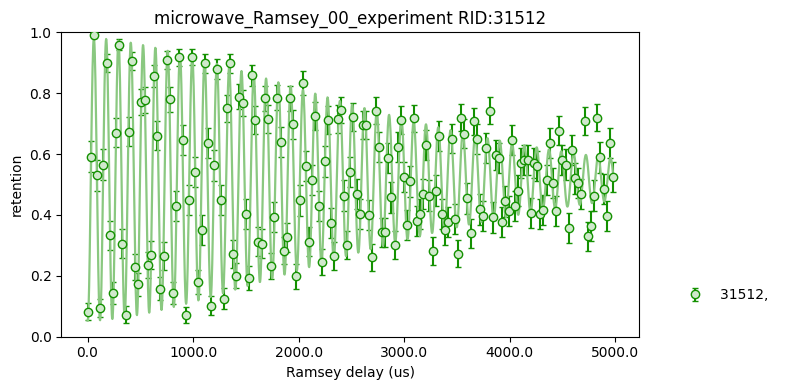

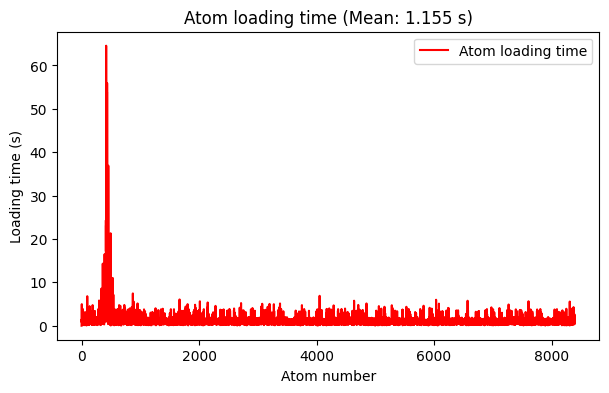

In [225]:
"""
Ramsey analysis and fitting. Does not work in 2D scans; only looks at scan_sequence1.

"""
file_indices = {
    8: '',
    # 11: ''
}

# file_indices = {i: '' for i in range(7, 18, 2)}

for idx, f_item in enumerate(file_indices.items()):
    f_idx, f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)

    # ### use this to limit the number of iterations to analyze. Comment out otherwise:
    # max_iter = 50
    # scan_sequence1 = scan_sequence1[:max_iter]
    # BothSPCMs_RO1 = BothSPCMs_RO1[:max_iter * n_measurements]
    # BothSPCMs_RO2 = BothSPCMs_RO2[:max_iter * n_measurements]

    print("experiment:", experiment_function)
    print("override:", override_ExperimentVariables)

    iterations = len(scan_sequence1)
    print("# of iterations: ", iterations)

    cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    xsteps_xform = lambda x: x
    xlabel = scan_variable1_name

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(
        BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, cutoff1, otsu=False
    )


    ############ Building xvals and yvals for fit, plot, etc. and masking invalid points
    mask   = (loading_rate_array > 0) & (n_atoms_loaded_array > 0)
    xvals  = xsteps_xform(scan_sequence1)[mask]
    yvals  = retention_array[mask]
    n_trials = n_atoms_loaded_array[mask].astype(float) # total trials per point

    ######### The errors. Use either binomial or standard
    yerrs = binomial_err(n_trials, yvals) # binomial
    # yerrs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_trials]) # standard 
    

    ########################  Ramsey fit 
    ###       [A, offset, phase, T2s, f_detuning, exponent]
    p0_guess = [0.5, 0.5, 3.14, 3.2e-3, +8600, 2]
    bounds   = ([0.4, 0.4, -2 * np.pi, 1e-3, 1000, 0.5], 
                  [0.6, 0.6, 2 * np.pi, 8e-3, 40000, 3])

    # model = lambda t, A, offset, phase, T2s, f_detuning: offset + A * (1+0.95*(t/T2s)**2)**(-3/2)*np.cos((2*np.pi*(f_detuning))*t - 3*np.arctan(0.97*t/T2s) + phase)
    model = lambda t, A, offset, phase, T2s, f_detuning, expon: offset + A * (np.exp(-(t/T2s)**expon)*np.cos((2*np.pi*(f_detuning))*t + phase))
    params = ['amplitude', 'offset', 'phase', 'T2s', 'f_detuning','expon']

    ### ensure sigmas are valid
    valid_sigma = np.isfinite(yerrs) & (yerrs > 0)
    if not np.all(valid_sigma):
        fallback = np.median(yerrs[valid_sigma]) if np.any(valid_sigma) else 1.0
        yerrs = np.where(valid_sigma, yerrs, fallback)

    ### weighted fit using yerrs
    popt, pcov = curve_fit(
        f=model,
        xdata=xvals,
        ydata=yvals,
        p0=p0_guess,
        bounds=bounds,
        sigma=yerrs,
        absolute_sigma=True,
        maxfev=20000
    )

    ### Compute 1σ uncertainties
    perr = np.sqrt(np.diag(pcov))
    
    ###Print all parameters, but only show uncertainty for T2s
    fit_str = ", ".join(
        f"{p} = {1e3*v:.2f} ± {1e3*perr[i]:.2f}" if p == "T2s" else f"{p} = {v:.3f}"
        for i, (p, v) in enumerate(zip(params, popt))
    )
    # ### Print all results with uncertainties
    # fit_str = ", ".join(
    #     f"{p} = {v:.5f} ± {e:.5f}" for p, v, e in zip(params, popt, perr)
    # )
    print(fit_str)

    
    ### High-res fit curve for smooth line
    hi_res_x = np.linspace(xvals[0], xvals[-1], 10 * len(xvals))
    yfit = model(hi_res_x, *popt)
    

    ############ Prepare data and plot (fit still in seconds)
    xvals_us    = xvals * 1e6 ### converting xvals from seconds to microseconds for nice axis in plot.
    hi_res_x_us = hi_res_x * 1e6
    
    series = [{
        "x": xvals_us,
        "y": yvals,
        "yerr": yerrs,                        
        "label": f"{rid}, {f_comment}",
        "color": color3,   
        "fit": (hi_res_x_us, yfit),             # yfit computed from seconds; just rescale x
        # "fit_style": {"linestyle": "--"}      # optional
    }]
    
    plot_series_with_fit(
        series,
        title=experiment_function + f" RID:{rid}",
        xlabel="Ramsey delay (us)",
        ylabel="retention",
        ylim=(0, 1),
        figsize=(8, 4),
        legend_out=True,
        save="Ramsey.pdf",
        grid=False
    )


#####  Plot Atom_loading_time 
mean_loading_time = np.mean(Atom_loading_time)
plt.figure(figsize=(7, 4))
plt.plot(Atom_loading_time, 'r-', label='Atom loading time')
plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)")
plt.legend(loc='best')
plt.show()

In [174]:
A, offset, phase, T2s, f_detuning, expon = popt

def R(t):
    return A * np.exp(-(t / T2s)**2)

R0 = R(0)
R1 = R(10e-6)
ratio = R1 / R0

print("R(0) =", R0)
print("R(1) =", R1)
print("Ratio =", ratio)

R(0) = 0.4422187231083334
R(1) = 0.4388011481342327
Ratio = 0.9922717542349209


In [176]:
T2s

0.00011353185648894564

### Ramsey old analysis - to delete

# Simple 1D scan - Fitting Rabi

experiment: microwave_map01_MWRFm11_experiment
override: {'t_FORT_drop':0*us,'t_microwave_pulse':2.6*us,'f_microwaves_dds':(339.104+0.03)*MHz,'t_delay_between_shots':0*us}
# of iterations:  100
amplitude=0.444814±0.0057, offset=0.496727±0.0024, f_R(Hz)=2868.39±2.7, phase(rad)=3.14141±0.02, T2R(s)=50±2.8e+04
Optical-pumping fidelity from visibility: F_pump = 0.8896 ± 0.0114


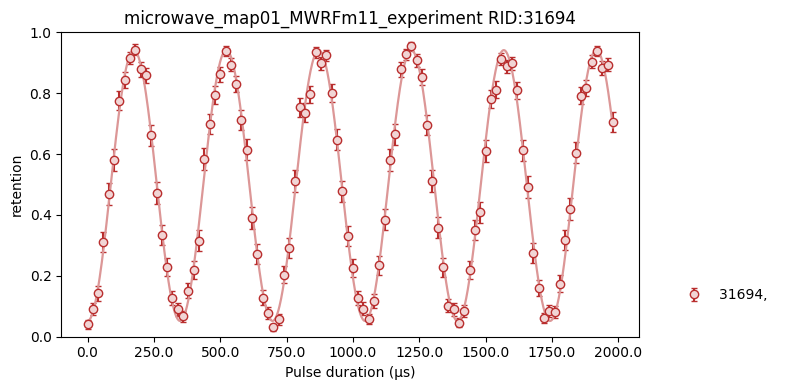

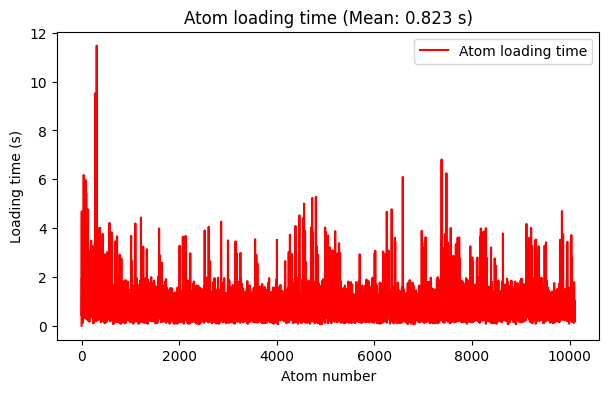

In [211]:
"""
Rabi oscillation analysis and fitting. Does not work in 2D scans; only looks at scan_sequence1.

"""
file_indices = {
    2: '',
    # 18: ''
}


for idx, f_item in enumerate(file_indices.items()):
    f_idx, f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)

    # ### use this to limit the number of iterations to analyze. Comment out otherwise:
    # max_iter = 25
    # scan_sequence1 = scan_sequence1[:max_iter]
    # BothSPCMs_RO1 = BothSPCMs_RO1[:max_iter * n_measurements]
    # BothSPCMs_RO2 = BothSPCMs_RO2[:max_iter * n_measurements]

    print("experiment:", experiment_function)
    print("override:", override_ExperimentVariables)

    iterations = len(scan_sequence1)
    print("# of iterations: ", iterations)

    cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    xsteps_xform = lambda x: x
    xlabel = scan_variable1_name

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(
        BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, cutoff1, otsu=False
    )


    ############ Building xvals and yvals for fit, plot, etc. and masking invalid points
    mask   = (loading_rate_array > 0) & (n_atoms_loaded_array > 0)
    xvals  = xsteps_xform(scan_sequence1)[mask]
    yvals  = retention_array[mask]
    n_trials = n_atoms_loaded_array[mask].astype(float) # total trials per point

    ######### The errors. Use either binomial or standard
    yerrs = binomial_err(n_trials, yvals) # binomial
    # yerrs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_trials]) # standard 


    #############  Rabi fit (damped cosine) 
    ###       [A, offset, f_R(Hz), phase(rad), T2R(s)]
    p0_guess = [0.5, 0.50, 2.8e3, np.pi, 10.0]
    bounds   = ([0.4, 0.20,   100.0, 0.0,  5.0e-4],
                [0.60, 0.80, 50e3,    2*np.pi,   50.0])

    model  = lambda t, A, offset, f_R, phase, T2R: offset + A * np.exp(-t/T2R) * np.cos(2*np.pi*f_R*t + phase)
    params = ['amplitude', 'offset', 'f_R(Hz)', 'phase(rad)', 'T2R(s)']


    ### ensure sigmas are valid
    valid_sigma = np.isfinite(yerrs) & (yerrs > 0)
    if not np.all(valid_sigma):
        fallback = np.median(yerrs[valid_sigma]) if np.any(valid_sigma) else 1.0
        yerrs = np.where(valid_sigma, yerrs, fallback)

    popt, pcov = curve_fit(
        f=model,
        xdata=xvals,
        ydata=yvals,
        p0=p0_guess,
        bounds=bounds,
        sigma=yerrs,
        absolute_sigma=True,
        maxfev=20000
    )


    ### errors from covariance
    perr = np.sqrt(np.diag(pcov))
    
    fit_str = ", ".join(
        f"{p}={v:.6g}±{dv:.2g}" for p, v, dv in zip(params, popt, perr)
    )
    print(fit_str)
    
    ### High-res fit curve for smooth line
    hi_res_x = np.linspace(xvals[0], xvals[-1], 10 * len(xvals))
    yfit = model(hi_res_x, *popt)
    
    ### pumping fidelity from fit
    A, offset, f_R, phase, T2R = popt
    A_err = perr[0]                  # error on amplitude
    
    F_pump = 2 * A
    F_pump_err = 2 * A_err    
    
    print(
        f"Optical-pumping fidelity from visibility: "
        f"F_pump = {F_pump:.4f} ± {F_pump_err:.4f}"
    )



    #################### Prepare data and plot (fit still in seconds)
    xvals_us    = xvals * 1e6 ### converting xvals from seconds to microseconds for nice axis in plot.
    hi_res_x_us = hi_res_x * 1e6
    
    series = [{
        "x": xvals_us,
        "y": yvals,
        "yerr": yerrs,                        
        "label": f"{rid}, {f_comment}",
        "color": color2,   
        "fit": (hi_res_x_us, yfit),             # yfit computed from seconds; just rescale x
        # "fit_style": {"linestyle": "--"}      # optional
    }]
    
    plot_series_with_fit(
        series,
        title=experiment_function + f" RID:{rid}",
        xlabel="Pulse duration (µs)",
        ylabel="retention",
        ylim=(0, 1),            
        legend_out=True,
        save="Rabi.pdf",
        grid=False
    )
    #################### plot end

#####  Plot Atom_loading_time 
mean_loading_time = np.mean(Atom_loading_time)
plt.figure(figsize=(7, 4))
plt.plot(Atom_loading_time, 'r-', label='Atom loading time')
plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)")
plt.legend(loc='best')
plt.show()

In [13]:
"""
Correcting the optical pumping fidelity for hyperfine-selective readout errors.
"""

### hyperfine-selective readout fidelity and error from Readout_and_blowaway_fidelity_2025.ipynb
F_hyperfine_selective_RO = 0.9881
dF_hyperfine_selective_RO = 0.0028

denom = 2*F_hyperfine_selective_RO - 1.0
F_pump_RO_corrected = F_pump / denom

dF_pump_RO_corrected = np.sqrt(
    (F_pump_err / denom)**2
    + ((2*F_pump * dF_hyperfine_selective_RO) / (denom**2))**2
)

print(f"Optical pumping fidelity (Readout corrected)   =  {F_pump_RO_corrected:.4f} ± {dF_pump_RO_corrected:.4f}")

Optical pumping fidelity (Readout corrected)   =  0.9871 ± 0.0123
